# Extract store info

Some additional information on the stores was made available in the
file `data/store.csv`.

In this notebook, we show how we combine this data with the sales information
and calculate some additional features.

We store the new features in `data/store_info.csv`.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load scripts from parent path
import sys, os
sys.path.insert(0, os.path.abspath('..'))

## Load sales data

In [10]:
from scripts.processing import load_train_data, process_data, add_week_month_info

train_raw = load_train_data()
train = add_week_month_info(train_raw)

train_raw.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,week,month
0,2013-01-01,1115.0,2.0,0.0,0.0,0.0,0.0,a,1.0,1,1
1,2013-01-01,379.0,2.0,0.0,0.0,0.0,0.0,a,1.0,1,1
2,2013-01-01,378.0,2.0,0.0,0.0,0.0,0.0,a,1.0,1,1
3,2013-01-01,377.0,2.0,0.0,0.0,0.0,0.0,a,1.0,1,1
4,2013-01-01,376.0,2.0,0.0,0.0,0.0,0.0,a,1.0,1,1


### Calculate monthly store sales numbers

From the sales data, we calculate the monthly sales and customers per store
and add them as features.

In [11]:
store_sales = train_raw.groupby(by=['Store', 'month']).agg(
    Store_Sales_mean=('Sales', 'mean'),
    Store_Customers_mean=('Customers', 'mean')
    )
store_sales = store_sales.reset_index()
store_sales

,Store,month,Store_Sales_mean,Store_Customers_mean
0,1.0,1,3926.966102,487.442623
1,1.0,2,4175.722222,508.716981
2,1.0,3,4273.250000,517.338983
3,1.0,4,3912.875000,471.948276
4,1.0,5,3784.733333,454.762712
...,...,...,...,...
13375,1115.0,8,4888.290323,351.000000
13376,1115.0,9,4336.900000,313.185185
13377,1115.0,10,4577.866667,326.689655
13378,1115.0,11,5263.888889,347.857143


### Load store details

Now we load the additional information on the stores.

For a description of these columns, see the README.

In [12]:
store_details_raw = pd.read_csv("../data/store.csv")
store_details_raw

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


### Extract Promo Information

Here we calculate whether a store has a promo running or not.

We calculate this from the column `PromoInterval` which
has the month when a store is running a promo stored as a list.

In [13]:
def get_promo_info(store_details_raw):
    """ Extract the promo info from the data."""
    col = store_details_raw.loc[:, 'PromoInterval'].str.split(',')
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    promo_info = pd.DataFrame(col.copy(), index=store_details_raw.loc[:, 'Store'])
    for month_id, month in enumerate(months):
        promo_info.loc[:, f"{month_id+1}"] = col.apply(lambda x: (1 if month in x else 0) if type(x) is not float else 0)
    promo_info = promo_info.drop('PromoInterval', axis=1)
    return promo_info

promo_info = get_promo_info(store_details_raw)

## Combine all info and save

We now merge all the extracted features and save them at `data/store_info.csv`.

During training, this info can be loaded and mapped onto the sales data.

We added the following features:
 - `Store`: The ID of the store, for mapping to the sales data.
 - `StoreType`: The type of store, differing between four models, a, b, c, d.
 - `Assortment`: The type of goods that the store is carrying, a = basic, b = extra, c = extended.
 - `CompetitionDistance`: The distance to the nearest competing store, in meters.
 - `month`: The month for which average sales and customers were calculated.
 - `Store_Sales_mean`: The mean sales for this store and month.
 - `Store_Customers_mean`: The mean customers for this store and month.

In [14]:
# Cols to store
cols_to_store = ['Store', 'StoreType', 'Assortment', 'CompetitionDistance']
store_details = store_details_raw.loc[:, cols_to_store]
# Fill missing distances with 0
store_details.loc[:, 'CompetitionDistance'] = \
    store_details.loc[:, 'CompetitionDistance'].fillna(
        store_details.loc[:, 'CompetitionDistance'].mean())

# Add promo feature
# Don't use for now, is already in sales data.
# promo_info = get_promo_info(store_details_raw)

# Add sales
store_details = pd.merge(store_details, store_sales, how='left', on=['Store'])

# Save data
store_details.to_csv('../data/store_info.csv', index=False)

# Load data to check
store_info = pd.read_csv('../data/store_info.csv')
store_info

,Store,StoreType,Assortment,CompetitionDistance,month,Store_Sales_mean,Store_Customers_mean
0,1,c,a,1270.0,1,3926.966102,487.442623
1,1,c,a,1270.0,2,4175.722222,508.716981
2,1,c,a,1270.0,3,4273.250000,517.338983
3,1,c,a,1270.0,4,3912.875000,471.948276
4,1,c,a,1270.0,5,3784.733333,454.762712
...,...,...,...,...,...,...,...
13375,1115,d,c,5350.0,8,4888.290323,351.000000
13376,1115,d,c,5350.0,9,4336.900000,313.185185
13377,1115,d,c,5350.0,10,4577.866667,326.689655
13378,1115,d,c,5350.0,11,5263.888889,347.857143


## Store Info Correlations

 - We observe the highest correlation between Store_Sales_mean and Store_Customers_mean.
 - Various numerical features do not exhibit extremely high correlations. Therefore, we keep all of them.

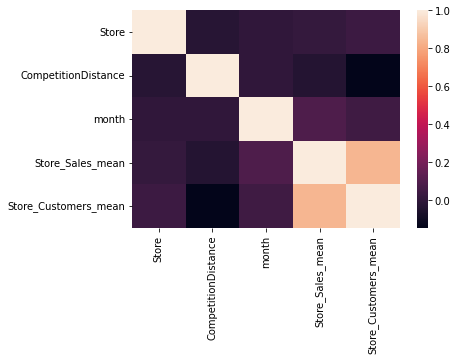

In [15]:
sns.heatmap(store_info.corr());